# **Quantum Algorithms in Qiskit**

This notebook presents clear, cell-by-cell implementations for QFT, IQFT, Phase Estimation, and Shor's Algorithm.

In [11]:
!pip install -q qiskit qiskit-aer pylatexenc matplotlib numpy


In [55]:

# Imports
from qiskit import transpile
from qiskit_aer import AerSimulator

simulator = AerSimulator()

import numpy as np
from math import pi, gcd
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt


**Quantum Fourier Transform (QFT)**

QFT transforms a quantum state from the computational basis to the Fourier basis using Hadamard and controlled phase gates.



In [58]:
def qft(n):
  qc = QuantumCircuit(n)

  for i in range(n):
      qc.h(i)
      for j in range(i+1, n):
          qc.cp(np.pi / (2 ** (j - i)), j, i)

    #swap qubits to reverse order
  for i in range(n // 2):
      qc.swap(i, n - i - 1)

  qc.name = "QFT"
  return qc

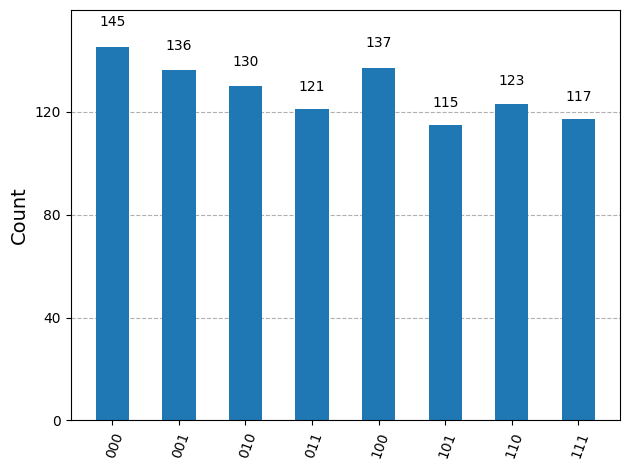

In [59]:

#sample implementation
#example state |101>
n= 3
qc= QuantumCircuit(n)
qc.x(0)
qc.x(2)

#append QFT and IQFT as instructions
qft_gate = qft(n).to_instruction()

qc.append(qft_gate, range(n))

qc.measure_all()

#unroll the circuit to the simulator's basis gates
unrolled_qc = qc.decompose()


result= sim.run(unrolled_qc).result()
counts= result.get_counts()
plot_histogram(counts)

**Inverse Quantum Fourier Transform (IQFT)**

IQFT reverses the QFT operation, restoring the original computational basis.

In [29]:
def iqft_circuit(n_qubits):
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits // 2):
        qc.swap(i, n_qubits - 1 - i)
    for j in reversed(range(n_qubits)):
        for k in reversed(range(j+1, n_qubits)):
            qc.cp(-pi / 2**(k-j), k, j)
        qc.h(j)
    return qc


In [30]:
# Apply IQFT to the QFT output
final_state_iqft = final_state.evolve(iqft_circuit(n))

print("\nInverse QFT Output Statevector:")
for i, amp in enumerate(final_state_iqft.data):
    print(f"|{i:0{n}b}⟩: amplitude = {amp.real:.4f}{amp.imag:+.4f}j")



Inverse QFT Output Statevector:
|0000⟩: amplitude = -0.0000-0.0000j
|0001⟩: amplitude = -0.0000+0.0000j
|0010⟩: amplitude = 1.0000+0.0000j
|0011⟩: amplitude = -0.0000-0.0000j
|0100⟩: amplitude = 0.0000+0.0000j
|0101⟩: amplitude = 0.0000-0.0000j
|0110⟩: amplitude = 0.0000-0.0000j
|0111⟩: amplitude = 0.0000+0.0000j
|1000⟩: amplitude = 0.0000+0.0000j
|1001⟩: amplitude = 0.0000-0.0000j
|1010⟩: amplitude = 0.0000-0.0000j
|1011⟩: amplitude = 0.0000+0.0000j
|1100⟩: amplitude = 0.0000+0.0000j
|1101⟩: amplitude = 0.0000-0.0000j
|1110⟩: amplitude = 0.0000-0.0000j
|1111⟩: amplitude = 0.0000+0.0000j


**QFT + IQFT (Identity Check)**

In [31]:
qc_full = QuantumCircuit(n)
qc_full.x(1)  # Prepare |0010⟩
qc_full.append(qft_circuit(n), range(n))
qc_full.append(iqft_circuit(n), range(n))

final_state_identity = Statevector.from_instruction(qc_full)

print("\nFinal Statevector after QFT + iQFT:")
for i, amp in enumerate(final_state_identity.data):
    print(f"|{i:0{n}b}⟩: amplitude = {amp.real:.4f}{amp.imag:+.4f}j")



Final Statevector after QFT + iQFT:
|0000⟩: amplitude = -0.0000-0.0000j
|0001⟩: amplitude = -0.0000+0.0000j
|0010⟩: amplitude = 1.0000+0.0000j
|0011⟩: amplitude = -0.0000-0.0000j
|0100⟩: amplitude = 0.0000+0.0000j
|0101⟩: amplitude = 0.0000-0.0000j
|0110⟩: amplitude = 0.0000-0.0000j
|0111⟩: amplitude = 0.0000+0.0000j
|1000⟩: amplitude = 0.0000+0.0000j
|1001⟩: amplitude = 0.0000-0.0000j
|1010⟩: amplitude = 0.0000-0.0000j
|1011⟩: amplitude = 0.0000+0.0000j
|1100⟩: amplitude = 0.0000+0.0000j
|1101⟩: amplitude = 0.0000-0.0000j
|1110⟩: amplitude = 0.0000-0.0000j
|1111⟩: amplitude = 0.0000+0.0000j


**Quantum Phase Estimation (QPE)**

QPE estimates the eigenvalue phase of a unitary operator.

/tmp/ipython-input-22-4256269063.py:20: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(t, inverse=True, do_swaps=True).to_gate()


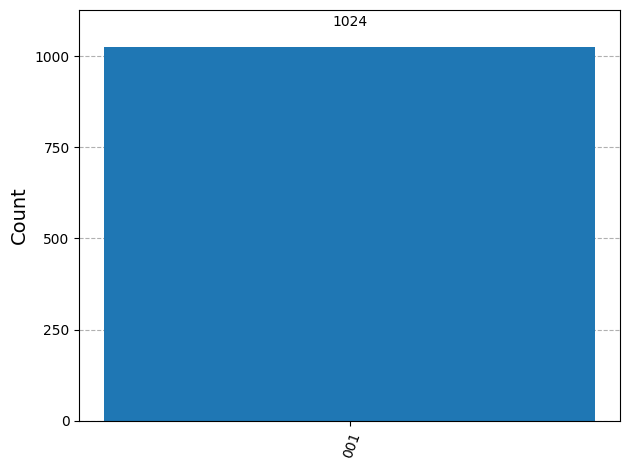

In [22]:
from qiskit.circuit.library import QFT

t = 3  # Number of counting (control) qubits
n = 1  # Number of target qubits

qc3 = QuantumCircuit(t + n, t)
qc3.h(range(t))      # Apply Hadamard to all control qubits
qc3.x(t)             # Prepare target in |1⟩

theta = 0.125
U = QuantumCircuit(1)
U.p(2 * pi * theta, 0)  # Unitary with known phase shift

for i in range(t):
    power = 2**i
    powered_U = U.power(power)
    controlled_U = powered_U.control()
    qc3.append(controlled_U, [i, t])

qft = QFT(t, inverse=True, do_swaps=True).to_gate()
qc3.append(qft, range(t))

qc3.measure(range(t), range(t))
qc3 = qc3.decompose(reps=10)  # Decompose for simulator compatibility

sim = AerSimulator()
result = sim.run(qc3, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)


**Shor's Algorithm**

Shor's Algorithm factors integers by finding the period of modular exponentiation.

In [23]:
def shors_period_finding(N=1555, a=7):
    n_qubits = 4
    qc = QuantumCircuit(2 * n_qubits, n_qubits)
    for i in range(n_qubits):
        qc.h(i)
    for i in range(n_qubits):
        if i % 2 == 0:
            qc.cx(i, n_qubits + i % n_qubits)
    qc.append(qft_circuit(n_qubits), range(n_qubits))
    qc.measure(range(n_qubits), range(n_qubits))
    return qc

N = 1555
a = 7
print(f"Factoring N = {N} using a = {a}")
print(f"Period verification: {a}^4 mod {N} = {(a**4) % N}")

qc = shors_period_finding(N, a)
job = sim.run(transpile(qc, sim), shots=1000)
result = job.result()
counts = result.get_counts()
print("Quantum Period Finding Results")
for state, count in sorted(counts.items()):
    if count > 50:
        decimal_value = int(state, 2)
        print(f"|{state}⟩= {count/1000:.3f}, decimal - {decimal_value}")


Factoring N = 1555 using a = 7
Period verification: 7^4 mod 1555 = 846
Quantum Period Finding Results
|0000⟩= 0.225, decimal - 0
|0010⟩= 0.134, decimal - 2
|0011⟩= 0.119, decimal - 3
|1000⟩= 0.114, decimal - 8
|1011⟩= 0.109, decimal - 11
|1100⟩= 0.095, decimal - 12
|1111⟩= 0.118, decimal - 15


In [24]:
r = 4  # Period found (example)
factor1 = gcd(a**(r//2) - 1, N)
factor2 = gcd(a**(r//2) + 1, N)
print("Classical post-processing:")
print(f"gcd({a}^{r//2} - 1, {N}) = {factor1}")
print(f"gcd({a}^{r//2} + 1, {N}) = {factor2}")
if factor1 > 1 and factor1 < N:
    print(f"Found factors: {factor1} × {N//factor1} = {N}")
elif factor2 > 1 and factor2 < N:
    print(f"Found factors: {factor2} × {N//factor2} = {N}")


Classical post-processing:
gcd(7^2 - 1, 1555) = 1
gcd(7^2 + 1, 1555) = 5
Found factors: 5 × 311 = 1555
